In [112]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [94]:
# global constants
Sv=1.e9 # m^3/sec

In [108]:
# salinity only, linear forcing 
input_data = np.load('data/input_sal_linear.npy')
output_data = np.load('data/output_sal_linear.npy')

In [109]:
X_train, X_rem, y_train, y_rem = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [110]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

Y_train = keras.utils.to_categorical(y_train)
Y_val = keras.utils.to_categorical(y_val)
Y_test = keras.utils.to_categorical(y_test)

In [111]:
# defining the MLP
model = Sequential()
model.add(Dense(12, input_dim=4, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
# Train the model on the training set and validate on the validation set
model_eval = model.fit(X_train_scaled, Y_train, epochs=10, batch_size=8, validation_data=(X_val_scaled, Y_val))

Epoch 1/10
10000/10000 [==============================] - 10s 960us/step - loss: 0.0234 - accuracy: 0.9884 - val_loss: 1.4860e-05 - val_accuracy: 1.0000
Epoch 2/10
10000/10000 [==============================] - 10s 974us/step - loss: 4.1665e-05 - accuracy: 1.0000 - val_loss: 1.4086e-06 - val_accuracy: 1.0000
Epoch 3/10
10000/10000 [==============================] - 9s 925us/step - loss: 6.1250e-05 - accuracy: 1.0000 - val_loss: 4.1502e-07 - val_accuracy: 1.0000
Epoch 4/10
10000/10000 [==============================] - 9s 934us/step - loss: 1.7289e-05 - accuracy: 1.0000 - val_loss: 1.2462e-06 - val_accuracy: 1.0000
Epoch 5/10
10000/10000 [==============================] - 9s 936us/step - loss: 1.0006e-04 - accuracy: 1.0000 - val_loss: 1.6154e-07 - val_accuracy: 1.0000
Epoch 6/10
10000/10000 [==============================] - 9s 931us/step - loss: 4.3976e-05 - accuracy: 1.0000 - val_loss: 1.3686e-07 - val_accuracy: 1.0000
Epoch 7/10
10000/10000 [==============================] - 9s 927us

In [101]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

313/313 [==============================] - 0s 934us/step - loss: 1.6457e-06 - accuracy: 1.0000
Test loss: 1.6457045148854377e-06
Test accuracy: 1.0


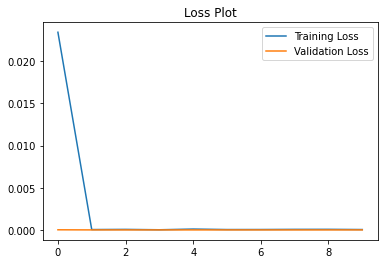

In [102]:
plt.plot(model_eval.history['loss'], label='Training Loss');
plt.plot(model_eval.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot');
plt.legend();

In [103]:
y_pred_all = model.predict(input_scaled)

3125/3125 [==============================] - 2s 652us/step


In [104]:
y_labels_all = np.argmax(y_pred_all, axis=-1)

In [105]:
false_indices_sal_linear = []
for i in range(len(y_labels_all)):
    if y_labels_all[i] != output_data[i]:
        false_indices_sal_linear.append(i)

In [106]:
qplot = np.load('data/q_sal_linear.npy')

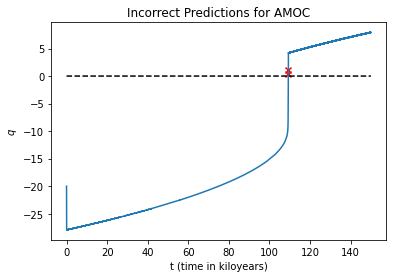

In [107]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC');
plt.scatter([input_data[:, 0][i] for i in false_indices_sal_linear], [qplot[i]/Sv for i in false_indices_sal_linear], marker='x', c='red');

In [114]:
# training the ensemble 
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train_scaled, Y_train,
                    batch_size=8,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_scaled, Y_val),
                    callbacks=[es])#,
    os.makedirs("models", exist_ok=True)
    model.save('models/stommel_model_linear_'+str(i)+'.h5')

0
1
2
3
4
5
6
7
8
9


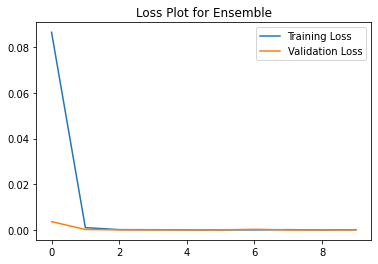

In [117]:
plt.plot(history.history['loss'], label='Training Loss');
plt.plot(history.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot for Ensemble')
plt.legend();

In [128]:
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models/stommel_model_linear_'+str(i)+'.h5')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_scaled, Y_test)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

0
313/313 [==============================] - 0s 741us/step - loss: 4.8539e-09 - accuracy: 1.0000
Test loss: 4.8539421371174285e-09
Test accuracy: 1.0
1
313/313 [==============================] - 0s 777us/step - loss: 1.8827e-06 - accuracy: 1.0000
Test loss: 1.8827082612915547e-06
Test accuracy: 1.0
2
313/313 [==============================] - 0s 847us/step - loss: 2.0723e-06 - accuracy: 1.0000
Test loss: 2.0722886802104767e-06
Test accuracy: 1.0
3
313/313 [==============================] - 0s 905us/step - loss: 0.5827 - accuracy: 0.7306
Test loss: 0.5826919078826904
Test accuracy: 0.7305999994277954
4
313/313 [==============================] - 0s 834us/step - loss: 6.8530e-08 - accuracy: 1.0000
Test loss: 6.853040446230807e-08
Test accuracy: 1.0
5
313/313 [==============================] - 0s 787us/step - loss: 4.5259e-08 - accuracy: 1.0000
Test loss: 4.5258961023364463e-08
Test accuracy: 1.0
6
313/313 [==============================] - 0s 1ms/step - loss: 5.0522e-08 - accuracy: 1.0000

In [121]:
datapredicted_results_ensemble = np.nan * np.zeros((10, input_scaled.shape[0], 2))

for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models/stommel_model_linear_'+str(i)+'.h5')
    datapredicted = model.predict(input_scaled)
    datapredicted_results_ensemble[i,...] = datapredicted

0
3125/3125 [==============================] - 2s 605us/step
1
3125/3125 [==============================] - 2s 583us/step
2
3125/3125 [==============================] - 2s 594us/step
3
3125/3125 [==============================] - 2s 590us/step
4
3125/3125 [==============================] - 2s 619us/step
5
3125/3125 [==============================] - 2s 657us/step
6
3125/3125 [==============================] - 2s 663us/step
7
3125/3125 [==============================] - 2s 708us/step
8
3125/3125 [==============================] - 2s 637us/step
9
3125/3125 [==============================] - 2s 610us/step


In [122]:
y_pred_ensemble = np.mean(datapredicted_results_ensemble, 0).argmax(axis=-1)

In [123]:
false_indices_linear_ensemble = []

In [124]:
for i in range(len(y_pred_ensemble)):
    if y_pred_ensemble[i] != output_data[i]:
        false_indices_linear_ensemble.append(i)

In [126]:
false_indices_linear_ensemble

[]

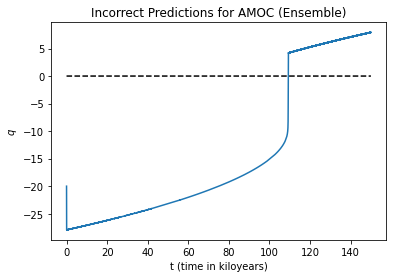

In [125]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC (Ensemble)');
plt.scatter([input_data[:, 0][i] for i in false_indices_linear_ensemble], [qplot[i]/Sv for i in false_indices_linear_ensemble], marker='x', c='red');

In [140]:
# salinity only, sine forcing 
input_data = np.load('data/input_sal_sine.npy')
output_data = np.load('data/output_sal_sine.npy')

In [141]:
X_train, X_rem, y_train, y_rem = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [142]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

Y_train = keras.utils.to_categorical(y_train)
Y_val = keras.utils.to_categorical(y_val)
Y_test = keras.utils.to_categorical(y_test)

In [55]:
# Train the model on the training set and validate on the validation set
model_eval = model.fit(X_train_scaled, Y_train, epochs=10, batch_size=8, validation_data=(X_val_scaled, Y_val))

Epoch 1/10
10000/10000 [==============================] - 13s 1ms/step - loss: 0.0782 - accuracy: 0.9817 - val_loss: 0.0070 - val_accuracy: 0.9991
Epoch 2/10
10000/10000 [==============================] - 11s 1ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.0033 - val_accuracy: 0.9992
Epoch 3/10
10000/10000 [==============================] - 12s 1ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0021 - val_accuracy: 0.9992
Epoch 4/10
10000/10000 [==============================] - 12s 1ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0031 - val_accuracy: 0.9985
Epoch 5/10
10000/10000 [==============================] - 11s 1ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 0.9992
Epoch 6/10
10000/10000 [==============================] - 11s 1ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 7/10
10000/10000 [==============================] - 11s 1ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0

In [56]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

313/313 [==============================] - 0s 747us/step - loss: 0.0010 - accuracy: 0.9995
Test loss: 0.001022834680043161
Test accuracy: 0.9994999766349792


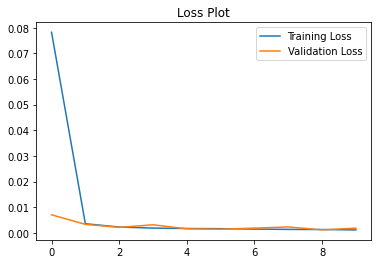

In [57]:
plt.plot(model_eval.history['loss'], label='Training Loss');
plt.plot(model_eval.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot');
plt.legend();

In [58]:
y_pred_all = model.predict(input_scaled)

3125/3125 [==============================] - 2s 681us/step


In [59]:
y_labels_all = np.argmax(y_pred_all, axis=-1)

In [91]:
false_indices_sal_sine = []
for i in range(len(y_labels_all)):
    if y_labels_all[i] != output_data[i]:
        false_indices_sal_sine.append(i)

In [143]:
qplot = np.load('data/q_sal_sine.npy')

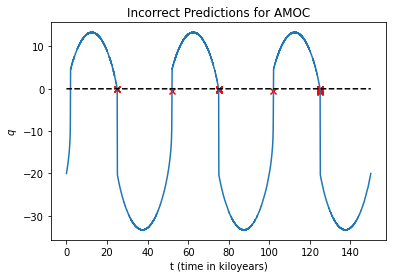

In [93]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC');
plt.scatter([input_data[:, 0][i]for i in false_indices_sal_sine], [qplot[i]/Sv for i in false_indices_sal_sine], marker='x', c='red');

In [144]:
# training the ensemble 
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train_scaled, Y_train,
                    batch_size=8,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_scaled, Y_val),
                    callbacks=[es])#,
    os.makedirs("models", exist_ok=True)
    model.save('models/stommel_model_sine_'+str(i)+'.h5')

0
1
Epoch 9: early stopping
2
3
4
5
6
7
8
9


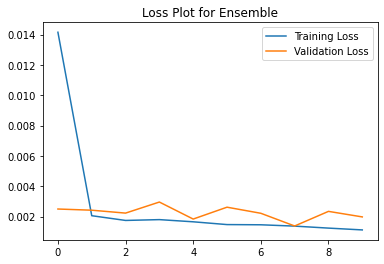

In [145]:
plt.plot(history.history['loss'], label='Training Loss');
plt.plot(history.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot for Ensemble')
plt.legend();

In [146]:
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models/stommel_model_sine_'+str(i)+'.h5')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_scaled, Y_test)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

0
313/313 [==============================] - 0s 747us/step - loss: 0.0012 - accuracy: 0.9992
Test loss: 0.0012007567565888166
Test accuracy: 0.9991999864578247
1
313/313 [==============================] - 0s 830us/step - loss: 0.0015 - accuracy: 0.9994
Test loss: 0.001528840628452599
Test accuracy: 0.9994000196456909
2
313/313 [==============================] - 0s 746us/step - loss: 9.2933e-04 - accuracy: 0.9997
Test loss: 0.0009293275070376694
Test accuracy: 0.9997000098228455
3
313/313 [==============================] - 0s 814us/step - loss: 0.0016 - accuracy: 0.9991
Test loss: 0.0016203389968723059
Test accuracy: 0.9991000294685364
4
313/313 [==============================] - 0s 766us/step - loss: 8.6701e-04 - accuracy: 0.9995
Test loss: 0.0008670133538544178
Test accuracy: 0.9994999766349792
5
313/313 [==============================] - 0s 735us/step - loss: 0.0011 - accuracy: 0.9995
Test loss: 0.0011291761184111238
Test accuracy: 0.9994999766349792
6
313/313 [======================

In [147]:
datapredicted_results_ensemble = np.nan * np.zeros((10, input_scaled.shape[0], 2))

for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models/stommel_model_sine_'+str(i)+'.h5')
    datapredicted = model.predict(input_scaled)
    datapredicted_results_ensemble[i,...] = datapredicted

0
3125/3125 [==============================] - 2s 581us/step
1
3125/3125 [==============================] - 2s 584us/step
2
3125/3125 [==============================] - 2s 639us/step
3
3125/3125 [==============================] - 2s 595us/step
4
3125/3125 [==============================] - 2s 696us/step
5
3125/3125 [==============================] - 2s 615us/step
6
3125/3125 [==============================] - 2s 658us/step
7
3125/3125 [==============================] - 2s 657us/step
8
3125/3125 [==============================] - 2s 665us/step
9
3125/3125 [==============================] - 2s 674us/step


In [148]:
y_pred_ensemble = np.mean(datapredicted_results_ensemble, 0).argmax(axis=-1)

In [149]:
false_indices_sine_ensemble = []

In [150]:
for i in range(len(y_pred_ensemble)):
    if y_pred_ensemble[i] != output_data[i]:
        false_indices_sine_ensemble.append(i)

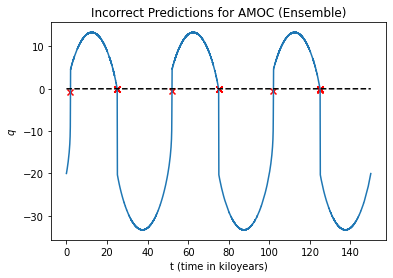

In [151]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC (Ensemble)');
plt.scatter([input_data[:, 0][i] for i in false_indices_sine_ensemble], [qplot[i]/Sv for i in false_indices_sine_ensemble], marker='x', c='red');